### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import auc
from sklearn import svm

### Read labels

In [3]:
labels = pd.read_csv('train_labels.csv') 

### Read train data from the two files and merge them in a single dataframe and drop the Id column

In [6]:
train_feat1 = pd.read_csv('train_SBM.csv')
train_feat2 = pd.read_csv('train_FNC.csv')
both_train = pd.merge(train_feat1, train_feat2)
both_train = both_train.drop(columns= ['Id'])
print(both_train.head())

   SBM_map1  SBM_map2  SBM_map3  SBM_map4  SBM_map5  SBM_map6  SBM_map7  \
0  0.725065 -0.639254  0.353069 -0.981707 -1.419971 -0.441321 -0.264192   
1 -1.328855  0.502970  0.013232  1.128496 -0.070738  0.398476 -0.466051   
2  0.732268 -1.241554  0.654942 -0.289216  0.158316  0.029165  1.439242   
3 -0.343917 -1.052519 -1.150521  0.765989  0.923129  0.674052 -0.492673   
4 -0.208685 -0.562697 -0.362164  1.025571  0.151690 -0.130410 -1.105922   

   SBM_map8  SBM_map10  SBM_map13   ...      FNC369    FNC370   FNC371  \
0  0.711579   0.641798   0.339658   ...     0.18743  0.163770  0.17686   
1 -0.435455   0.342847  -0.672254   ...     0.59834 -0.477880  0.26634   
2 -0.832816   1.285468  -2.132901   ...     0.22866 -0.000816  0.25860   
3  1.282388  -1.914583  -1.269851   ...     0.42881  0.711570  0.56593   
4  0.502029  -0.097735   1.561833   ...     0.41688 -0.435600  0.32104   

     FNC372    FNC373    FNC374   FNC375   FNC376    FNC377   FNC378  
0  0.074728  0.148600  0.343230  

### Select most important features from the 410 features based on Variance Threshold

In [7]:
print(both_train.shape)

(86, 410)


In [8]:
sel = VarianceThreshold(threshold=(.3 * (1 - .3)))
both_train = pd.DataFrame(sel.fit_transform(both_train))

In [9]:
print(both_train.shape)

(86, 33)


### Divide the data into random 70% train and 30% test data

In [10]:
msk = np.random.rand(len(both_train)) < 0.7

In [11]:
test_data = both_train[~msk]
train_data = both_train[msk]
labels_train = labels[msk]
labels_test = labels[~msk]

### Train model using ID3 decision tree classifie: default parameters

In [12]:
model = DecisionTreeClassifier()
model.fit(train_data, labels_train.Class)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Make predictions on the test data

In [14]:
predictions = model.predict(test_data)
print(predictions)

[0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1]


### Convert labels into numpy array for iterations

In [15]:
labels_test = labels[~msk]
labels_test = np.array(labels_test.Class)

### Calculate the correctly classified data for accuracy

In [16]:
count = 0
for i in range(len(predictions)):
    if predictions[i] == labels_test[i]:
        count += 1
print(count, len(predictions))
acc = float(count)/float(len(predictions))
print("Accuracy :", acc)

15 26
Accuracy : 0.5769230769230769


### To plot the ROC curve as in the paper, we calculate the true positives, true negatives, false positives and false negatives

In [17]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for i in range(len(predictions)):
    if predictions[i] == 1 and labels_test[i] == 1:
        true_pos += 1
    elif predictions[i] == 1 and labels_test[i] == 0:
        false_pos += 1
    elif predictions[i] == 0 and labels_test[i] == 1:
        false_neg += 1
    elif predictions[i] == 0 and labels_test[i] == 0:
        true_neg += 1

In [18]:
print(true_neg,true_pos,false_neg,false_pos, true_neg+true_pos+false_neg+false_pos, len(predictions) )

9 6 8 3 26 26


### True Positive Rate is calculated as TPR = TP/ (TP + FN) and False Positive Rate as FPR = FP/(FP + TN)

In [19]:
tpr = float(true_pos)/(float(true_pos) + float(false_neg))
fpr = float(false_pos)/(float(false_pos) + float(true_neg))
print(tpr,fpr)

0.42857142857142855 0.25


### Making the plot consistent, we convert the TPR and FPR in the proper format and draw the plot as shown below with the AUC accuracy calculated from the TPR and FPR

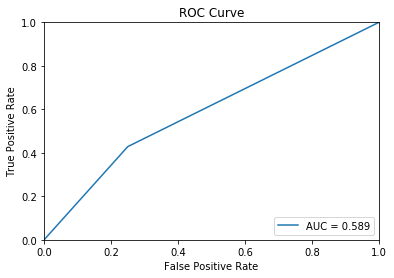

In [20]:
tpr_arr = [0.0, tpr, 1.0]
fpr_arr = [0.0, fpr, 1.0]
plt.title('ROC Curve')
plt.plot(fpr_arr, tpr_arr, label = 'AUC = %0.3f' % auc(fpr_arr, tpr_arr))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()